# Using CDC data to provide valuable business idea to combat unhealthy behaviors
### *Submitted by Vikram Seshadri*

## Introduction
Center for Disease Control collects census data on 500 major cities in the US every year. The dataset that they collected in 2018 which includes 2016 model-based small area estimates for 27 measures of chronic disease related to unhealthy behaviors, health outcomes, and preventive services [1]. 

CDC has identified obesity, less sleep (<7 hours a day), less physical activity, binge drinking, and smoking as unhealthy behaviors. These unhealthy behaviors are correctable by identifying the cause and motivating people to get into healthy habits. For example, obesity was identified as one of the unhealthy behaviors in the dataset. Obesity can be caused by eating unhealthy food, less physical activity, and lifestyle. All the three causes for obesity can be corrected by making good choices on food, signing up for gym/sports activity, and leading a good and healthy lifestyle. This project will focus on obesity, lack of sleep and physical activity for analysis.

## Business problem
The first problem would be to find the locations that are more seriously affected by the unhealthy behaviors in each of the categories such as obesity, less sleep, and physical inactivity. Once these places are identified, it would be pertinent to find out the reason for such high numbers in unhealthy behavior. For example, is it possible that there are many fast-food restaurants in places where there is an obesity problem? Similarly, is there a lack of gym/outdoor recreational facilities such as parks/trials to mitigate a lack of physical activity.
Once the cause is found, there is an opportunity for the appropriate business startup in each of these locations to improve the quality of life long-term while being profitable. For example, setting up gymnasiums and sports complex in locations where there is a lack of physical activity is both profitable and improves the quality of life of people in that area.

## Reference
1. https://chronicdata.cdc.gov/500-Cities/500-Cities-Local-Data-for-Better-Health-2018-relea/6vp6-wxuq. (This is a project that was funded by the Robert Wood Johnson Foundation.

Import pandas library for working with dataframes

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import json # library to handle JSON files
import numpy as np
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library
import requests

## Data
The dataset used for this problem will be obtained from the CDC website as a CSV file. The data will be filtered to contain only the information on unhealthy behavior.
The top 10 locations where each of the unhealthy behavior is prevalent will be taken for this project.
Use the latitude and longitude locations of these locations and obtain the details of the venues, specifically the type of restaurants, gymnasium, yoga studio, and parks and recreations.
Depending on the details of the venues (or the lack thereof), an appropriate business model for each location can be recommended. Tools such as K-Means clustering can be used to find out the locations that will benefit from similar businesses that can improve the lifestyle.

In [2]:
df_cdc_2018 = pd.read_csv('500_Cities__Local_Data_for_Better_Health__2018_release.csv')

In [3]:
df_cdc_2018.columns

Index(['Year', 'StateAbbr', 'StateDesc', 'CityName', 'GeographicLevel',
       'DataSource', 'Category', 'UniqueID', 'Measure', 'Data_Value_Unit',
       'DataValueTypeID', 'Data_Value_Type', 'Data_Value',
       'Low_Confidence_Limit', 'High_Confidence_Limit',
       'Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 'PopulationCount',
       'GeoLocation', 'CategoryID', 'MeasureId', 'CityFIPS', 'TractFIPS',
       'Short_Question_Text'],
      dtype='object')

### Data preparation

In [4]:
df_cdc_2018.drop(columns=['StateDesc','DataSource','UniqueID','Data_Value_Unit','Data_Value_Type','Data_Value_Footnote_Symbol','Data_Value_Footnote','TractFIPS','CityFIPS','Short_Question_Text'],inplace=True)

In [5]:
df_cdc_2018 = df_cdc_2018[df_cdc_2018.GeographicLevel == 'City']

In [6]:
df_cdc_2018.reset_index(drop=True,inplace=True)

In [7]:
print(df_cdc_2018.shape)
df_cdc_2018.head()

(28000, 14)


,Year,StateAbbr,CityName,GeographicLevel,Category,Measure,DataValueTypeID,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,PopulationCount,GeoLocation,CategoryID,MeasureId
0,2016,AL,Birmingham,City,Prevention,Current lack of health insurance among adults ...,AgeAdjPrv,19.5,19.1,19.9,212237,"(33.5275663773, -86.7988174678)",PREVENT,ACCESS2
1,2016,AL,Birmingham,City,Prevention,Current lack of health insurance among adults ...,CrdPrv,19.2,18.8,19.5,212237,"(33.5275663773, -86.7988174678)",PREVENT,ACCESS2
2,2016,AL,Birmingham,City,Health Outcomes,Arthritis among adults aged >=18 Years,AgeAdjPrv,29.3,29.1,29.4,212237,"(33.5275663773, -86.7988174678)",HLTHOUT,ARTHRITIS
3,2016,AL,Birmingham,City,Health Outcomes,Arthritis among adults aged >=18 Years,CrdPrv,29.3,29.1,29.4,212237,"(33.5275663773, -86.7988174678)",HLTHOUT,ARTHRITIS
4,2016,AL,Birmingham,City,Unhealthy Behaviors,Binge drinking among adults aged >=18 Years,AgeAdjPrv,13.0,13.0,13.1,212237,"(33.5275663773, -86.7988174678)",UNHBEH,BINGE


#### Converting geolocation to latitude and longitude 

In [8]:
df_cdc_2018['GeoLocation']=df_cdc_2018['GeoLocation'].astype('str')

In [9]:
df_cdc_2018[['lat', 'long']] = df_cdc_2018['GeoLocation'].str.split(',', expand=True)
df_cdc_2018['lat'] = df_cdc_2018['lat'].str.strip('(').astype('float')
df_cdc_2018['long'] = df_cdc_2018['long'].str.strip(')').astype('float')

In [10]:
df_cdc_2018.drop(columns=['GeoLocation','GeographicLevel'],inplace=True)
df_cdc_2018.columns

Index(['Year', 'StateAbbr', 'CityName', 'Category', 'Measure',
       'DataValueTypeID', 'Data_Value', 'Low_Confidence_Limit',
       'High_Confidence_Limit', 'PopulationCount', 'CategoryID', 'MeasureId',
       'lat', 'long'],
      dtype='object')

In [11]:
df_cdc_2018.head()

,Year,StateAbbr,CityName,Category,Measure,DataValueTypeID,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,PopulationCount,CategoryID,MeasureId,lat,long
0,2016,AL,Birmingham,Prevention,Current lack of health insurance among adults ...,AgeAdjPrv,19.5,19.1,19.9,212237,PREVENT,ACCESS2,33.527566,-86.798817
1,2016,AL,Birmingham,Prevention,Current lack of health insurance among adults ...,CrdPrv,19.2,18.8,19.5,212237,PREVENT,ACCESS2,33.527566,-86.798817
2,2016,AL,Birmingham,Health Outcomes,Arthritis among adults aged >=18 Years,AgeAdjPrv,29.3,29.1,29.4,212237,HLTHOUT,ARTHRITIS,33.527566,-86.798817
3,2016,AL,Birmingham,Health Outcomes,Arthritis among adults aged >=18 Years,CrdPrv,29.3,29.1,29.4,212237,HLTHOUT,ARTHRITIS,33.527566,-86.798817
4,2016,AL,Birmingham,Unhealthy Behaviors,Binge drinking among adults aged >=18 Years,AgeAdjPrv,13.0,13.0,13.1,212237,UNHBEH,BINGE,33.527566,-86.798817


In [12]:
df_cdc_2018_UnHBeh = df_cdc_2018[df_cdc_2018.CategoryID == 'UNHBEH']
df_cdc_2018_Prevent = df_cdc_2018[df_cdc_2018.CategoryID == 'PREVENT']
df_cdc_2018_HlthOut = df_cdc_2018[df_cdc_2018.CategoryID == 'HLTHOUT']
print(df_cdc_2018_UnHBeh.shape,df_cdc_2018_Prevent.shape,df_cdc_2018_HlthOut.shape)

(5000, 14) (10000, 14) (13000, 14)


In [13]:
df_cdc_2018_UnHBeh_AAP = df_cdc_2018_UnHBeh[df_cdc_2018_UnHBeh.DataValueTypeID == 'AgeAdjPrv']
df_cdc_2018_UnHBeh_CP = df_cdc_2018_UnHBeh[df_cdc_2018_UnHBeh.DataValueTypeID == 'CrdPrv']

In [14]:
df_cdc_2018_UnHBeh_AAP.head(2)

,Year,StateAbbr,CityName,Category,Measure,DataValueTypeID,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,PopulationCount,CategoryID,MeasureId,lat,long
4,2016,AL,Birmingham,Unhealthy Behaviors,Binge drinking among adults aged >=18 Years,AgeAdjPrv,13.0,13.0,13.1,212237,UNHBEH,BINGE,33.527566,-86.798817
29,2016,AL,Birmingham,Unhealthy Behaviors,Current smoking among adults aged >=18 Years,AgeAdjPrv,22.6,22.2,22.9,212237,UNHBEH,CSMOKING,33.527566,-86.798817


In [15]:
df_cdc_2018_UnHBeh_AAP.rename(columns={'Data_Value':'AAP_value','Low_Confidence_Limit':'AAP_LCL','High_Confidence_Limit':'AAP_HCL'},inplace=True)
df_cdc_2018_UnHBeh_AAP.drop(columns='DataValueTypeID',inplace=True)
df_cdc_2018_UnHBeh_CP.rename(columns={'Data_Value':'CP_value','Low_Confidence_Limit':'CP_LCL','High_Confidence_Limit':'CP_HCL'},inplace=True)
df_cdc_2018_UnHBeh_CP.drop(columns='DataValueTypeID',inplace=True)
print(df_cdc_2018_UnHBeh_AAP.columns,df_cdc_2018_UnHBeh_CP.columns)

Index(['Year', 'StateAbbr', 'CityName', 'Category', 'Measure', 'AAP_value',
       'AAP_LCL', 'AAP_HCL', 'PopulationCount', 'CategoryID', 'MeasureId',
       'lat', 'long'],
      dtype='object') Index(['Year', 'StateAbbr', 'CityName', 'Category', 'Measure', 'CP_value',
       'CP_LCL', 'CP_HCL', 'PopulationCount', 'CategoryID', 'MeasureId', 'lat',
       'long'],
      dtype='object')


C:\Users\DivyaVikram\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\DivyaVikram\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [16]:
df_cdc_2018_UnHBeh_CP.head()

,Year,StateAbbr,CityName,Category,Measure,CP_value,CP_LCL,CP_HCL,PopulationCount,CategoryID,MeasureId,lat,long
5,2016,AL,Birmingham,Unhealthy Behaviors,Binge drinking among adults aged >=18 Years,13.2,13.1,13.2,212237,UNHBEH,BINGE,33.527566,-86.798817
30,2016,AL,Birmingham,Unhealthy Behaviors,Current smoking among adults aged >=18 Years,22.3,21.9,22.6,212237,UNHBEH,CSMOKING,33.527566,-86.798817
40,2016,AL,Birmingham,Unhealthy Behaviors,No leisure-time physical activity among adults...,35.6,35.2,36.0,212237,UNHBEH,LPA,33.527566,-86.798817
46,2016,AL,Birmingham,Unhealthy Behaviors,Obesity among adults aged >=18 Years,41.7,41.5,41.9,212237,UNHBEH,OBESITY,33.527566,-86.798817
54,2016,AL,Birmingham,Unhealthy Behaviors,Sleeping less than 7 hours among adults aged >...,41.5,41.3,41.6,212237,UNHBEH,SLEEP,33.527566,-86.798817


In [17]:
df_cdc_2018_UnHBeh_final=pd.merge(df_cdc_2018_UnHBeh_AAP,df_cdc_2018_UnHBeh_CP, how='left', on=['Year', 'CityName', 'MeasureId', 'StateAbbr', 'Category', 'Measure', 'PopulationCount', 'CategoryID', 'lat', 'long'])

In [18]:
df_cdc_2018_UnHBeh_final.drop(columns=['Category','CategoryID','Measure'],inplace=True)

### Dataframe containing 500 cities and their corresponding percentages of population with specific unhealthy behaviors

In [19]:
df_cdc_2018_UnHBeh_final.head(10)

,Year,StateAbbr,CityName,AAP_value,AAP_LCL,AAP_HCL,PopulationCount,MeasureId,lat,long,CP_value,CP_LCL,CP_HCL
0,2016,AL,Birmingham,13.0,13.0,13.1,212237,BINGE,33.527566,-86.798817,13.2,13.1,13.2
1,2016,AL,Birmingham,22.6,22.2,22.9,212237,CSMOKING,33.527566,-86.798817,22.3,21.9,22.6
2,2016,AL,Birmingham,35.8,35.4,36.2,212237,LPA,33.527566,-86.798817,35.6,35.2,36.0
3,2016,AL,Birmingham,42.6,42.4,42.7,212237,OBESITY,33.527566,-86.798817,41.7,41.5,41.9
4,2016,AL,Birmingham,41.8,41.7,42.0,212237,SLEEP,33.527566,-86.798817,41.5,41.3,41.6
5,2016,AL,Hoover,18.0,17.9,18.2,81619,BINGE,33.376760,-86.805194,17.8,17.6,17.9
6,2016,AL,Hoover,13.9,13.3,14.5,81619,CSMOKING,33.376760,-86.805194,14.1,13.4,14.7
7,2016,AL,Hoover,20.2,19.7,20.8,81619,LPA,33.376760,-86.805194,20.4,19.9,21.0
8,2016,AL,Hoover,28.9,28.5,29.2,81619,OBESITY,33.376760,-86.805194,29.2,28.9,29.6
9,2016,AL,Hoover,32.8,32.5,33.2,81619,SLEEP,33.376760,-86.805194,32.9,32.6,33.3


In [20]:
df_cdc_2018_UnHBeh_final.insert(1,'Location',df_cdc_2018_UnHBeh_final['CityName']+','+df_cdc_2018_UnHBeh_final['StateAbbr'])
df_cdc_2018_UnHBeh_final.drop(columns=['StateAbbr','CityName','Year'],inplace=True)
print(df_cdc_2018_UnHBeh_final.shape)
df_cdc_2018_UnHBeh_final.head()

(2500, 11)


,Location,AAP_value,AAP_LCL,AAP_HCL,PopulationCount,MeasureId,lat,long,CP_value,CP_LCL,CP_HCL
0,"Birmingham,AL",13.0,13.0,13.1,212237,BINGE,33.527566,-86.798817,13.2,13.1,13.2
1,"Birmingham,AL",22.6,22.2,22.9,212237,CSMOKING,33.527566,-86.798817,22.3,21.9,22.6
2,"Birmingham,AL",35.8,35.4,36.2,212237,LPA,33.527566,-86.798817,35.6,35.2,36.0
3,"Birmingham,AL",42.6,42.4,42.7,212237,OBESITY,33.527566,-86.798817,41.7,41.5,41.9
4,"Birmingham,AL",41.8,41.7,42.0,212237,SLEEP,33.527566,-86.798817,41.5,41.3,41.6


In [21]:
df_cdc_2018_UnHBeh_overall = df_cdc_2018_UnHBeh_final[df_cdc_2018_UnHBeh_final.MeasureId != 'CSMOKING']
df_cdc_2018_UnHBeh_overall = df_cdc_2018_UnHBeh_overall[df_cdc_2018_UnHBeh_overall.MeasureId != 'BINGE']
df_cdc_2018_UnHBeh_overall_unsorted = df_cdc_2018_UnHBeh_overall.copy()
df_cdc_2018_UnHBeh_overall.sort_values(by='AAP_value', ascending=False,inplace=True)
df_cdc_2018_UnHBeh_overall.reset_index(drop=True,inplace=True)
df_cdc_2018_UnHBeh_overall.head(30)

,Location,AAP_value,AAP_LCL,AAP_HCL,PopulationCount,MeasureId,lat,long,CP_value,CP_LCL,CP_HCL
0,"Detroit,MI",50.1,50.0,50.2,713777,SLEEP,42.384702,-83.105318,49.8,49.7,49.9
1,"Camden,NJ",49.6,49.3,49.9,77344,SLEEP,39.936191,-75.107296,49.8,49.5,50.1
2,"Gary,IN",49.0,48.7,49.3,80294,OBESITY,41.590478,-87.347291,49.1,48.8,49.4
3,"Newark,NJ",48.9,48.8,49.1,277140,SLEEP,40.726069,-74.175300,49.4,49.2,49.6
4,"Gary,IN",48.8,48.5,49.1,80294,SLEEP,41.590478,-87.347291,48.1,47.8,48.4
5,"Flint,MI",48.8,48.6,49.0,102434,SLEEP,43.023634,-83.692064,48.7,48.5,49.0
6,"Camden,NJ",48.6,47.9,49.3,77344,LPA,39.936191,-75.107296,46.7,46.0,47.4
7,"Albany,GA",47.5,47.1,47.9,77434,SLEEP,31.577604,-84.176324,47.1,46.7,47.5
8,"Detroit,MI",47.4,47.3,47.5,713777,OBESITY,42.384702,-83.105318,47.0,46.9,47.1
9,"Honolulu,HI",47.4,47.3,47.5,953207,SLEEP,21.458804,-157.973297,46.9,46.8,47.0


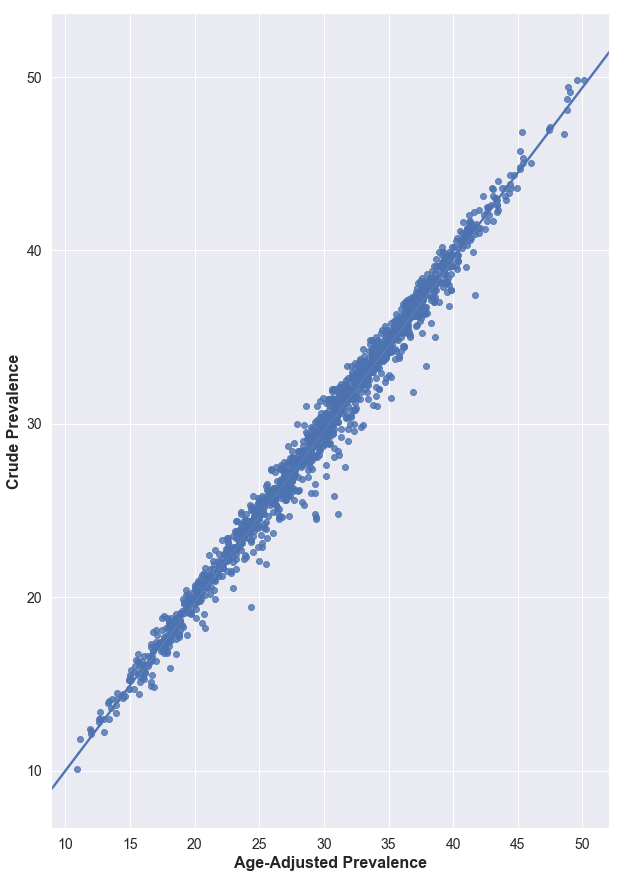

In [229]:
import seaborn as sns
AAPvsCP=sns.regplot(x='AAP_value',y='CP_value',data=df_cdc_2018_UnHBeh_overall_unsorted)
AAPvsCP
plt.xlabel('Age-Adjusted Prevalence',fontsize=16,fontweight='bold')
plt.ylabel('Crude Prevalence',fontsize=16,fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('AAPvsCP_new.png')

#### Separating unhealthy behaviors into Obesity, Less Physical activity, and Lack of sleep into three dataframes

In [22]:
df_cdc_2018_UnHBeh_final_Obesity = df_cdc_2018_UnHBeh_final[df_cdc_2018_UnHBeh_final.MeasureId == 'OBESITY']
df_cdc_2018_UnHBeh_final_LPA = df_cdc_2018_UnHBeh_final[df_cdc_2018_UnHBeh_final.MeasureId == 'LPA']
df_cdc_2018_UnHBeh_final_Sleep = df_cdc_2018_UnHBeh_final[df_cdc_2018_UnHBeh_final.MeasureId == 'SLEEP']

In [23]:
df_cdc_2018_UnHBeh_final_Obesity.head()

,Location,AAP_value,AAP_LCL,AAP_HCL,PopulationCount,MeasureId,lat,long,CP_value,CP_LCL,CP_HCL
3,"Birmingham,AL",42.6,42.4,42.7,212237,OBESITY,33.527566,-86.798817,41.7,41.5,41.9
8,"Hoover,AL",28.9,28.5,29.2,81619,OBESITY,33.376760,-86.805194,29.2,28.9,29.6
13,"Huntsville,AL",33.3,33.0,33.5,180105,OBESITY,34.698969,-86.638704,32.6,32.4,32.8
18,"Mobile,AL",39.7,39.6,39.9,195111,OBESITY,30.677625,-88.118448,39.0,38.9,39.2
23,"Montgomery,AL",36.9,36.7,37.2,205764,OBESITY,32.347265,-86.267706,36.4,36.2,36.6


#### The obesity dataset will contain 15 locations with high percentage of population with obesity and 15 locations with low percentage of obesity. With the presence of these two extremities along with foursquare, we hope to understand the reasons why one place has higher obesity compared to others.

In [24]:
def highs_and_lows(df, sort_by_value,num_of_top, num_of_bottom):
    temp = df.sort_values(by=sort_by_value,ascending=False).head(num_of_top)
    temp_low = df.sort_values(by=sort_by_value,ascending=False).tail(num_of_bottom)
    temp = temp.append(temp_low)
    temp.reset_index(inplace=True,drop=True)
    return(temp)

In [25]:
df_2018_obesity=highs_and_lows(df_cdc_2018_UnHBeh_final_Obesity,'AAP_value',15,15)
df_2018_obesity.head()

,Location,AAP_value,AAP_LCL,AAP_HCL,PopulationCount,MeasureId,lat,long,CP_value,CP_LCL,CP_HCL
0,"Gary,IN",49.0,48.7,49.3,80294,OBESITY,41.590478,-87.347291,49.1,48.8,49.4
1,"Detroit,MI",47.4,47.3,47.5,713777,OBESITY,42.384702,-83.105318,47.0,46.9,47.1
2,"Flint,MI",45.4,45.2,45.6,102434,OBESITY,43.023634,-83.692064,45.0,44.8,45.2
3,"Jackson,MS",44.5,44.3,44.8,173514,OBESITY,32.316272,-90.212453,43.6,43.3,43.9
4,"Brownsville,TX",44.4,44.0,44.7,175023,OBESITY,25.998198,-97.456634,43.8,43.5,44.2


#### Similarly, the low physical activity population dataset also contains 15 high and low percentage sets.

In [26]:
df_2018_LPA=highs_and_lows(df_cdc_2018_UnHBeh_final_LPA,'AAP_value',15,15)
df_2018_LPA.head(30)

,Location,AAP_value,AAP_LCL,AAP_HCL,PopulationCount,MeasureId,lat,long,CP_value,CP_LCL,CP_HCL
0,"Camden,NJ",48.6,47.9,49.3,77344,LPA,39.936191,-75.107296,46.7,46.0,47.4
1,"Hialeah,FL",45.3,44.6,45.9,224669,LPA,25.869627,-80.304529,46.8,46.2,47.4
2,"Passaic,NJ",44.9,43.9,45.8,69781,LPA,40.857458,-74.128112,43.6,42.6,44.5
3,"Paterson,NJ",44.3,43.8,44.7,146199,LPA,40.914687,-74.162418,43.3,42.8,43.8
4,"Trenton,NJ",43.4,42.7,44.0,84913,LPA,40.223729,-74.763994,42.2,41.6,42.8
5,"Union City,NJ",43.4,42.5,44.4,66455,LPA,40.767461,-74.032294,42.6,41.6,43.6
6,"Newark,NJ",43.1,42.7,43.5,277140,LPA,40.726069,-74.175300,41.7,41.3,42.1
7,"Miami,FL",41.6,41.2,42.0,399457,LPA,25.782296,-80.221565,42.2,41.8,42.6
8,"Miami Gardens,FL",41.2,40.4,42.0,107167,LPA,25.943263,-80.242533,40.7,39.9,41.5
9,"Youngstown,OH",41.2,40.7,41.8,66982,LPA,41.099329,-80.646319,42.0,41.4,42.6


#### and the same for lack of sleep population.

In [27]:
df_2018_sleep=highs_and_lows(df_cdc_2018_UnHBeh_final_Sleep,'AAP_value',15,15)
df_2018_sleep.head()

,Location,AAP_value,AAP_LCL,AAP_HCL,PopulationCount,MeasureId,lat,long,CP_value,CP_LCL,CP_HCL
0,"Detroit,MI",50.1,50.0,50.2,713777,SLEEP,42.384702,-83.105318,49.8,49.7,49.9
1,"Camden,NJ",49.6,49.3,49.9,77344,SLEEP,39.936191,-75.107296,49.8,49.5,50.1
2,"Newark,NJ",48.9,48.8,49.1,277140,SLEEP,40.726069,-74.175300,49.4,49.2,49.6
3,"Flint,MI",48.8,48.6,49.0,102434,SLEEP,43.023634,-83.692064,48.7,48.5,49.0
4,"Gary,IN",48.8,48.5,49.1,80294,SLEEP,41.590478,-87.347291,48.1,47.8,48.4


## Foursquare details for retriving venues. We will limit our search to 100 venues within 10 km from the location.

In [28]:
CLIENT_ID = 'KFQB4CA4OB0VCSZFMGBYRF3CWIUU5TVCPRNQXU3QXYXZ4VPT' # your Foursquare ID
CLIENT_SECRET = '2JP0S2ZVUZHSAXVJS53UYQOKZ0M1UE5SWDQ2GAMAA34EKNOC' # your Foursquare Secret
VERSION = '20190727' # Foursquare API version
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KFQB4CA4OB0VCSZFMGBYRF3CWIUU5TVCPRNQXU3QXYXZ4VPT
CLIENT_SECRET:2JP0S2ZVUZHSAXVJS53UYQOKZ0M1UE5SWDQ2GAMAA34EKNOC


##### Function to retrieve nearby venues from foursquare for given Categories and add it to a dataframe

In [29]:
def getNearbyVenues(names, latitudes, longitudes, CategoryID, radius=20000):
    
   
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
          # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?categoryId='       
        CID = ''
        for strings in CategoryID:
            CID = strings+','+CID
        CID =CID[:-1]
        url_part2 = '&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,  CLIENT_SECRET,VERSION, 
                                                                                     lat, lng, radius, LIMIT)
        url = url+CID+url_part2
             
        # make the GET request
        results = requests.get(url).json()["response"]["venues"]
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v["categories"][0]["shortName"], 
            v["location"]['lat'],  
            v["location"]['lng']) for v in results])
        
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'Location Lat', 
                  'Location Long', 
                  'Venue', 
                  'Venue Category', 
                  'Venue Lat', 
                  'Venue Long']
    print("Completed Foursquare query!!!")
    return(nearby_venues)

#### To understand reasons for obesity in a particular location, the venues containing food, physical activity, and medical centers are used as categories. These locations will potentially help us in clustering and/or classifying places that can be associated with obesity issue.

In [30]:
College_Gym = '4bf58dd8d48988d1b2941735'
Food = '4d4b7105d754a06374d81259'
Outdoor_and_rec = '4d4b7105d754a06377d81259'
Medical_centers = '4bf58dd8d48988d104941735'

CatID = [College_Gym, Food, Outdoor_and_rec, Medical_centers]

obesity_venues = getNearbyVenues(names=df_2018_obesity['Location'], latitudes=df_2018_obesity['lat'],
                                 longitudes=df_2018_obesity['long'], CategoryID=CatID)

Gary,IN
Detroit,MI
Flint,MI
Jackson,MS
Brownsville,TX
Camden,NJ
Macon,GA
Kansas City,KS
Dayton,OH
Shreveport,LA
Birmingham,AL
Reading,PA
Youngstown,OH
St. Joseph,MO
Kalamazoo,MI
Alhambra,CA
Santa Clara,CA
Alameda,CA
Carlsbad,CA
Torrance,CA
Longmont,CO
Johns Creek,GA
San Francisco,CA
Sunnyvale,CA
Pleasanton,CA
Union City,CA
Irvine,CA
Boulder,CO
Milpitas,CA
Fremont,CA
Completed Foursquare query!!!


In [31]:
obesity_venues.shape

(1380, 7)

In [161]:
obesity_venues.head()

,Location,Location Lat,Location Long,Venue,Venue Category,Venue Lat,Venue Long
0,"Gary,IN",41.590478,-87.347291,Starbucks,Coffee Shop,41.545950,-87.509370
1,"Gary,IN",41.590478,-87.347291,Chicago Skyway,Bridge,41.719509,-87.545325
2,"Gary,IN",41.590478,-87.347291,Albanese Confectionery,Candy Store,41.470291,-87.269804
3,"Gary,IN",41.590478,-87.347291,Starbucks,Coffee Shop,41.600668,-87.558552
4,"Gary,IN",41.590478,-87.347291,Panera Bread,Bakery,41.565249,-87.508483


In [33]:
print('There are {} uniques categories.'.format(len(obesity_venues['Venue Category'].unique())))

There are 172 uniques categories.


#### Function to perform onehot encoding, given the category on which the dummies has to be created. This function also groups it by specific category and in our case it will be location.

In [34]:
def onehot_encoding(df, category, groupby_category):
    temp_onehot = pd.get_dummies(df[category], prefix="", prefix_sep="")
    temp_onehot.insert(0, groupby_category, df[groupby_category], True)
    temp_grouped = temp_onehot.groupby(groupby_category).mean().reset_index()
    return(temp_grouped)

In [35]:
obesity_grouped = onehot_encoding(obesity_venues,'Venue Category','Location')

In [36]:
obesity_grouped.head()

,Location,American,Arcade,Asian,Athletics & Sports,BBQ,Bakery,Bank,Bar,Baseball,...,Tea Room,Tex-Mex,Theme Park,Trail,Travel,Truck Stop,University,Veterinarians,Waterfront,Wings
0,"Alameda,CA",0.000000,0.0,0.0,0.0,0.000000,0.020408,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.020408,0.000000,0.0,0.0,0.0,0.0,0.0
1,"Alhambra,CA",0.043478,0.0,0.0,0.0,0.000000,0.021739,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.043478,0.000000,0.0,0.0,0.0,0.0,0.0
2,"Birmingham,AL",0.023810,0.0,0.0,0.0,0.023810,0.023810,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.023810,0.000000,0.0,0.0,0.0,0.0,0.0
3,"Boulder,CO",0.040816,0.0,0.0,0.0,0.000000,0.000000,0.020408,0.040816,0.0,...,0.020408,0.0,0.0,0.040816,0.000000,0.0,0.0,0.0,0.0,0.0
4,"Brownsville,TX",0.000000,0.0,0.0,0.0,0.020408,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.020408,0.040816,0.0,0.0,0.0,0.0,0.0


In [37]:
obesity_grouped.shape

(30, 173)

In [38]:
num_top_venues = 5

for city in obesity_grouped['Location']:
    print("----"+city+"----")
    temp = obesity_grouped[obesity_grouped['Location'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alameda,CA----
           venue  freq
0           Park  0.20
1          Plaza  0.08
2  Gym / Fitness  0.06
3  Historic Site  0.06
4            Gym  0.06


----Alhambra,CA----
           venue  freq
0            Gym  0.09
1           Park  0.09
2  Gym / Fitness  0.07
3       American  0.04
4           Café  0.04


----Birmingham,AL----
           venue  freq
0      Fast Food  0.21
1  Grocery Store  0.17
2            Gym  0.10
3    Coffee Shop  0.10
4        Medical  0.05


----Boulder,CO----
         venue  freq
0  Coffee Shop  0.12
1          Gym  0.08
2         Park  0.06
3     American  0.04
4    Ice Cream  0.04


----Brownsville,TX----
         venue  freq
0    Fast Food  0.14
1   Playground  0.06
2      Mexican  0.06
3  Coffee Shop  0.06
4      Burgers  0.04


----Camden,NJ----
               venue  freq
0  Convenience Store  0.17
1               Park  0.15
2           Hospital  0.09
3        Coffee Shop  0.07
4              Plaza  0.07


----Carlsbad,CA----
           venue  f

#### The two functions below are used to return the most common venues and to form a dataframe with the top n venues for a given location.

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
def sorted_venues(df_grouped, column_name, num_top_venues):
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Location']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    df_sorted = pd.DataFrame(columns=columns)
    df_sorted[column_name] = df_grouped[column_name]

    for ind in np.arange(df_grouped.shape[0]):
        df_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)
    return(df_sorted)

In [41]:
num_top_venues = 10
obesity_venues_sorted = sorted_venues(obesity_grouped, 'Location', num_top_venues)

In [42]:
obesity_venues_sorted.head()

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Alameda,CA",Park,Plaza,Historic Site,Gym,Gym / Fitness,Grocery Store,Bridge,National Park,Scenic Lookout,Outdoor Sculpture
1,"Alhambra,CA",Park,Gym,Gym / Fitness,American,Trail,Coffee Shop,Plaza,Café,French,Entertainment
2,"Birmingham,AL",Fast Food,Grocery Store,Coffee Shop,Gym,Hospital,Park,Medical,Golf Driving Range,Gym / Fitness,Food Court
3,"Boulder,CO",Coffee Shop,Gym,Park,American,Bar,Mountain,Pub,Ice Cream,Tacos,Fast Food
4,"Brownsville,TX",Fast Food,Coffee Shop,Mexican,Playground,Grocery Store,Sporting Goods,Travel,Seafood,Burgers,Restaurant


#### Function to perform K-Means clustering on the data and to add those cluster labels to the location dataset.

In [43]:
def perform_kmeans(df_grouped,without_column,kclusters):
    df_grouped_clustering = df_grouped.drop(without_column, 1)
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)
    print(kmeans.labels_)
    return(kmeans.labels_)

In [44]:
def add_clusterlabels(df_sorted,values):
    df_sorted_with_cluster = df_sorted
    if 'Cluster Labels' in df_sorted_with_cluster:
        df_sorted_with_cluster.drop(columns = 'Cluster Labels', inplace=True)
    df_sorted_with_cluster.insert(0, 'Cluster Labels', values)
    return(df_sorted_with_cluster)

In [45]:
kclusters = 2
kmean_obesity = perform_kmeans(obesity_grouped,'Location',kclusters)

[1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0]


In [46]:
obesity_venues_sorted_with_cluster = add_clusterlabels(obesity_venues_sorted,kmean_obesity)
obesity_venues_sorted_with_cluster.head()

,Cluster Labels,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"Alameda,CA",Park,Plaza,Historic Site,Gym,Gym / Fitness,Grocery Store,Bridge,National Park,Scenic Lookout,Outdoor Sculpture
1,1,"Alhambra,CA",Park,Gym,Gym / Fitness,American,Trail,Coffee Shop,Plaza,Café,French,Entertainment
2,0,"Birmingham,AL",Fast Food,Grocery Store,Coffee Shop,Gym,Hospital,Park,Medical,Golf Driving Range,Gym / Fitness,Food Court
3,1,"Boulder,CO",Coffee Shop,Gym,Park,American,Bar,Mountain,Pub,Ice Cream,Tacos,Fast Food
4,0,"Brownsville,TX",Fast Food,Coffee Shop,Mexican,Playground,Grocery Store,Sporting Goods,Travel,Seafood,Burgers,Restaurant


In [47]:
df_2018_obesity.head()

,Location,AAP_value,AAP_LCL,AAP_HCL,PopulationCount,MeasureId,lat,long,CP_value,CP_LCL,CP_HCL
0,"Gary,IN",49.0,48.7,49.3,80294,OBESITY,41.590478,-87.347291,49.1,48.8,49.4
1,"Detroit,MI",47.4,47.3,47.5,713777,OBESITY,42.384702,-83.105318,47.0,46.9,47.1
2,"Flint,MI",45.4,45.2,45.6,102434,OBESITY,43.023634,-83.692064,45.0,44.8,45.2
3,"Jackson,MS",44.5,44.3,44.8,173514,OBESITY,32.316272,-90.212453,43.6,43.3,43.9
4,"Brownsville,TX",44.4,44.0,44.7,175023,OBESITY,25.998198,-97.456634,43.8,43.5,44.2


In [48]:
obesity_merged = df_2018_obesity.copy()
obesity_merged.drop(columns= ['MeasureId','AAP_LCL','AAP_HCL','CP_value','CP_LCL','CP_HCL'],inplace=True)
obesity_merged = obesity_merged.join(obesity_venues_sorted.set_index('Location'), on='Location')

#### The obesity dataset was clustered into two sets to see what might be the main cause for a city to have high obesity issues. It can be seen that there are 4 locations that are mislabeled for high AAP values (0 mislabeled as 1) and one location that has low AAP value that is mislabeled with high AAP (1 mislabeled as 0).

Note that K-Means clustering can provide different results depending on the starting points for the centroid.
It is also interesting to note that the places that are marked 0 (high AAP values) also contain Fast Food as top venue. It is not conclusive, but probable that Fast Food places are one of the factors for obesity and placing with Fast food as prevalent venue may have obesity issues.

In [163]:
obesity_merged.head(30)

,Location,AAP_value,PopulationCount,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Gary,IN",49.0,80294,41.590478,-87.347291,1,Coffee Shop,Park,Hospital,Fast Food,Gym / Fitness,Food Court,Golf Course,Gym,Lake,American
1,"Detroit,MI",47.4,713777,42.384702,-83.105318,1,Gym / Fitness,Coffee Shop,Park,Hospital,Waterfront,Bridge,Athletics & Sports,Fast Food,Sandwiches,Restaurant
2,"Flint,MI",45.4,102434,43.023634,-83.692064,0,Coffee Shop,Fast Food,Hospital,Gym / Fitness,Lake,Park,Campground,Golf Course,Gym,American
3,"Jackson,MS",44.5,173514,32.316272,-90.212453,0,Fast Food,Hospital,Coffee Shop,Gym,Café,Gym / Fitness,Other Outdoors,Truck Stop,Doctor's Office,Sandwiches
4,"Brownsville,TX",44.4,175023,25.998198,-97.456634,0,Fast Food,Coffee Shop,Mexican,Playground,Grocery Store,Sporting Goods,Travel,Seafood,Burgers,Restaurant
5,"Camden,NJ",44.1,77344,39.936191,-75.107296,1,Convenience Store,Park,Hospital,Plaza,Coffee Shop,Sandwiches,Medical,Bridge,City Hall,Gym / Fitness
6,"Macon,GA",44.0,91351,32.832042,-83.649582,0,Fast Food,American,Seafood,Fried Chicken,Grocery Store,Medical,Mexican,Park,Playground,Hospital
7,"Kansas City,KS",43.8,145786,39.123462,-94.744192,1,BBQ,Hospital,Coffee Shop,Gym,Food Court,Grocery Store,Park,Gym / Fitness,Cafeteria,Bar
8,"Dayton,OH",43.5,141527,39.779768,-84.199793,0,Coffee Shop,Park,Fast Food,Hospital,Gym,Plaza,Gym / Fitness,Optical,Middle Eastern,Medical
9,"Shreveport,LA",43.4,199311,32.467162,-93.796224,0,Coffee Shop,American,Burgers,Fast Food,Mexican,Steakhouse,Breakfast,Café,Casino,Fried Chicken


#### Visualize the clusters in Folium map

In [164]:
address = 'USA'
geolocator = Nominatim(user_agent="USA_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of  United States are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of  United States are 39.7837304, -100.4458825.


In [165]:
# create map
obesity_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
colors_array = ['red','blue']
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, AAPob in zip(obesity_merged['lat'], obesity_merged['long'], obesity_merged['Location'], obesity_merged['Cluster Labels'], obesity_merged['AAP_value']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=AAPob*0.25,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(obesity_clusters)
       
obesity_clusters

In [162]:
obesity_clusters.save('obesity_save2.jpeg')

In [53]:
df_cdc_2018_UnHBeh_overall_unsorted.head()

,Location,AAP_value,AAP_LCL,AAP_HCL,PopulationCount,MeasureId,lat,long,CP_value,CP_LCL,CP_HCL
2,"Birmingham,AL",35.8,35.4,36.2,212237,LPA,33.527566,-86.798817,35.6,35.2,36.0
3,"Birmingham,AL",42.6,42.4,42.7,212237,OBESITY,33.527566,-86.798817,41.7,41.5,41.9
4,"Birmingham,AL",41.8,41.7,42.0,212237,SLEEP,33.527566,-86.798817,41.5,41.3,41.6
7,"Hoover,AL",20.2,19.7,20.8,81619,LPA,33.376760,-86.805194,20.4,19.9,21.0
8,"Hoover,AL",28.9,28.5,29.2,81619,OBESITY,33.376760,-86.805194,29.2,28.9,29.6


#### It should be noted that AAP_value and CP_value bear a good linear relationship. Therefore it is sufficient to use AAP_value and not worry about CP_values for the rest of the analysis

In [55]:
df_cdc_2018_UHB = df_cdc_2018_UnHBeh_overall_unsorted.drop(columns=['AAP_LCL','AAP_HCL','CP_value','CP_LCL','CP_HCL'])

#### Separate the dataframes by Measure ID. Once separated, the AAP_value can be renamed with specific unhealthy behavior and then merged back. This will allow us to have all the three AAP_values of each unhealthy behavior and corresponding locations in single row.

In [56]:
df_obesity_all = df_cdc_2018_UHB[df_cdc_2018_UHB.MeasureId == 'OBESITY']
df_LPA_all = df_cdc_2018_UHB[df_cdc_2018_UHB.MeasureId == 'LPA']
df_sleep_all = df_cdc_2018_UHB[df_cdc_2018_UHB.MeasureId == 'SLEEP']

In [57]:
df_obesity_all.drop(columns = 'MeasureId',inplace=True)
df_LPA_all.drop(columns = 'MeasureId',inplace=True)
df_sleep_all.drop(columns = 'MeasureId',inplace=True)

C:\Users\DivyaVikram\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [58]:
df_obesity_all.rename(columns = {'AAP_value':'AAP_obesity'},inplace=True)

C:\Users\DivyaVikram\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [59]:
df_LPA_all.rename(columns = {'AAP_value':'AAP_LPA'},inplace=True)
df_sleep_all.rename(columns = {'AAP_value':'AAP_sleep'},inplace=True)

In [60]:
df_obesity_LPA_merged=pd.merge(df_obesity_all,df_LPA_all, how='left', on=['Location', 'PopulationCount','lat', 'long'])

In [61]:
df_UHB_merged = pd.merge(df_obesity_LPA_merged,df_sleep_all, how='left', on=['Location', 'PopulationCount','lat', 'long'])

In [62]:
df_UHB_merged = df_UHB_merged[['Location', 'PopulationCount','AAP_obesity','AAP_LPA','AAP_sleep','lat','long']]
df_UHB_merged.head()

,Location,PopulationCount,AAP_obesity,AAP_LPA,AAP_sleep,lat,long
0,"Birmingham,AL",212237,42.6,35.8,41.8,33.527566,-86.798817
1,"Hoover,AL",81619,28.9,20.2,32.8,33.376760,-86.805194
2,"Huntsville,AL",180105,33.3,25.9,38.3,34.698969,-86.638704
3,"Mobile,AL",195111,39.7,29.3,39.7,30.677625,-88.118448
4,"Montgomery,AL",205764,36.9,30.0,38.1,32.347265,-86.267706


In [63]:
df_UHB_merged.shape

(500, 7)

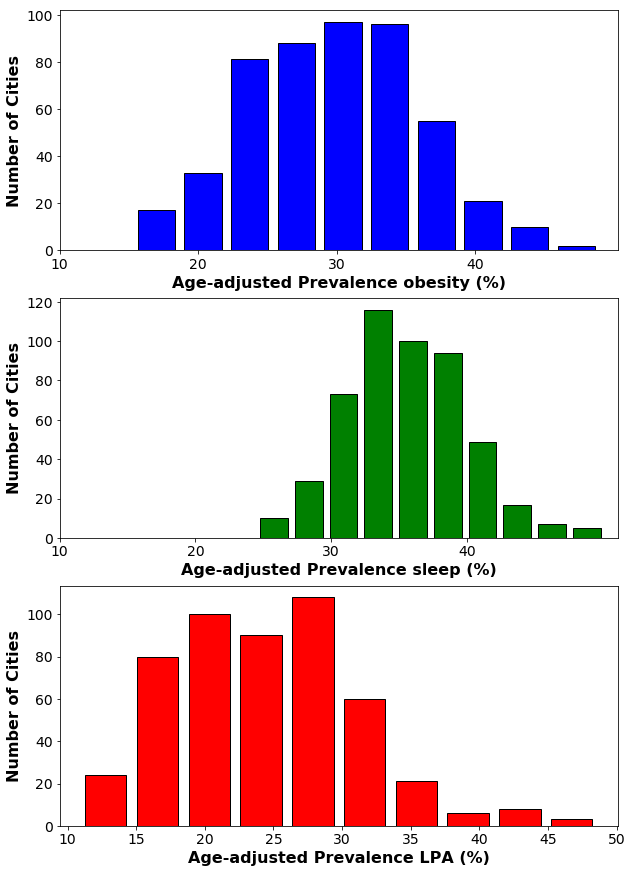

In [154]:
ticks = np.arange(10, 50,10)
plt.rcParams['figure.figsize'] = (10.0, 15.0)
fig, axs = plt.subplots(3, 1)

axs[0].hist(df_UHB_merged['AAP_obesity'], bins=10,facecolor='blue', edgecolor='black', rwidth=0.8)
axs[0].set_xlabel('Age-adjusted Prevalence obesity (%)',fontsize=16,fontweight='bold')
axs[0].set_ylabel('Number of Cities',fontsize=16,fontweight='bold')
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].set_xticks(ticks)

axs[1].hist(df_UHB_merged['AAP_sleep'], bins=10,facecolor='green', edgecolor='black', rwidth=0.8)
axs[1].set_xlabel('Age-adjusted Prevalence sleep (%)',fontsize=16,fontweight='bold')
axs[1].set_ylabel('Number of Cities',fontsize=16,fontweight='bold')
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].set_xticks(ticks)

axs[2].hist(df_UHB_merged['AAP_LPA'], bins=10,facecolor='red', edgecolor='black', rwidth=0.8)
axs[2].set_xlabel('Age-adjusted Prevalence LPA (%)',fontsize=16,fontweight='bold')
axs[2].set_ylabel('Number of Cities',fontsize=16,fontweight='bold')
axs[2].tick_params(axis='both', which='major', labelsize=14)
axs[1].set_xticks(ticks)

plt.savefig('hist_all_new.png')

In [155]:
df_UHB_merged['AAP_obesity'].describe()

count    500.000000
mean      29.785600
std        6.065305
min       15.300000
25%       25.300000
50%       29.800000
75%       33.900000
max       49.000000
Name: AAP_obesity, dtype: float64

In [156]:
df_UHB_merged['AAP_sleep'].describe()

count    500.000000
mean      35.521200
std        4.360966
min       24.500000
25%       32.400000
50%       35.350000
75%       38.500000
max       50.100000
Name: AAP_sleep, dtype: float64

In [157]:
df_UHB_merged['AAP_LPA'].describe()

count    500.00000
mean      24.33840
std        6.59031
min       10.90000
25%       19.07500
50%       24.25000
75%       28.80000
max       48.60000
Name: AAP_LPA, dtype: float64

In [160]:
from scipy import stats
print("Obesity:",stats.normaltest(df_UHB_merged['AAP_obesity']))
print("Sleep:",stats.normaltest(df_UHB_merged['AAP_sleep']))
print("LPA:",stats.normaltest(df_UHB_merged['AAP_LPA']))

Obesity: NormaltestResult(statistic=2.794492052357465, pvalue=0.24727702152527947)
Sleep: NormaltestResult(statistic=9.853381888855255, pvalue=0.007250455790564108)
LPA: NormaltestResult(statistic=21.314086495183613, pvalue=2.353449719231934e-05)


Write the data to excel sheet so that it can be used in the future without calling the original csv file.

In [64]:
df_UHB_merged.to_excel('df_UHB_merged.xlsx')

#### Prepare the dataset to perform K-Means on places with all the AAP values > 35 and plaves with all the AAP values <29. 

In [65]:
df_UHB_merged_top = df_UHB_merged[(df_UHB_merged.AAP_obesity>35.0) & (df_UHB_merged.AAP_LPA>35.0) & (df_UHB_merged.AAP_sleep>35.0)]

In [66]:
df_UHB_merged_bottom = df_UHB_merged[(df_UHB_merged.AAP_obesity<29.0) & (df_UHB_merged.AAP_LPA<29.0) & (df_UHB_merged.AAP_sleep<29.0)]

In [67]:
df_UHB_merged_final = df_UHB_merged_top.copy()
df_UHB_merged_final = df_UHB_merged_final.append(df_UHB_merged_bottom)
df_UHB_merged_final.reset_index(inplace=True,drop=True)
df_UHB_merged_final

,Location,PopulationCount,AAP_obesity,AAP_LPA,AAP_sleep,lat,long
0,"Birmingham,AL",212237,42.6,35.8,41.8,33.527566,-86.798817
1,"Hartford,CT",124775,37.2,36.7,41.0,41.766071,-72.683401
2,"Lauderhill,FL",66887,35.8,35.4,44.7,26.160558,-80.224128
3,"Albany,GA",77434,39.6,37.7,47.5,31.577604,-84.176324
4,"Macon,GA",91351,44.0,39.2,44.1,32.832042,-83.649582
5,"Cicero,IL",83891,36.7,36.2,35.6,41.844539,-87.759287
6,"Gary,IN",80294,49.0,39.1,48.8,41.590478,-87.347291
7,"Kansas City,KS",145786,43.8,35.6,36.9,39.123462,-94.744192
8,"Springfield,MA",153060,37.2,35.1,39.2,42.115498,-72.539525
9,"Detroit,MI",713777,47.4,35.7,50.1,42.384702,-83.105318


#### Since we have included lack of sleep as unhealthy behavior, spiritual centers and massage studios might be pertinent for the analysis.
#### *We can use the previously written function to obtain venues for given location, and also perform onehot encoding.*

In [68]:
College_Gym = '4bf58dd8d48988d1b2941735'
Food = '4d4b7105d754a06374d81259'
Outdoor_and_rec = '4d4b7105d754a06377d81259'
Medical_centers = '4bf58dd8d48988d104941735'
Spiritual_centers = '4bf58dd8d48988d131941735'
Massage_studio = '52f2ab2ebcbc57f1066b8b3c'

CatID_all = [College_Gym, Food, Outdoor_and_rec, Medical_centers, Spiritual_centers, Massage_studio]

UHB_venues = getNearbyVenues(names=df_UHB_merged_final['Location'], latitudes=df_UHB_merged_final['lat'],
                                 longitudes=df_UHB_merged_final['long'], CategoryID=CatID_all)

Birmingham,AL
Hartford,CT
Lauderhill,FL
Albany,GA
Macon,GA
Cicero,IL
Gary,IN
Kansas City,KS
Springfield,MA
Detroit,MI
Flint,MI
Camden,NJ
Newark,NJ
Passaic,NJ
Paterson,NJ
Trenton,NJ
Canton,OH
Cleveland,OH
Dayton,OH
Youngstown,OH
Reading,PA
Newport Beach,CA
Santa Barbara,CA
Arvada,CO
Boulder,CO
Centennial,CO
Denver,CO
Fort Collins,CO
Lakewood,CO
Longmont,CO
Loveland,CO
Westminster,CO
Boise City,ID
Meridian,ID
Iowa City,IA
Olathe,KS
Overland Park,KS
Bloomington,MN
Plymouth,MN
Missoula,MT
Santa Fe,NM
Rapid City,SD
Sandy,UT
Bellevue,WA
Completed Foursquare query!!!


In [69]:
print('There are {} uniques categories.'.format(len(UHB_venues['Venue Category'].unique())))

There are 183 uniques categories.


In [70]:
print(UHB_venues.shape)
UHB_venues.head(50)

(2043, 7)


,Location,Location Lat,Location Long,Venue,Venue Category,Venue Lat,Venue Long
0,"Birmingham,AL",33.527566,-86.798817,Topgolf,Golf Driving Range,33.529274,-86.807763
1,"Birmingham,AL",33.527566,-86.798817,Railroad Park,Park,33.509764,-86.807931
2,"Birmingham,AL",33.527566,-86.798817,Starbucks,Coffee Shop,33.421760,-86.699333
3,"Birmingham,AL",33.527566,-86.798817,Publix,Grocery Store,33.355765,-86.843055
4,"Birmingham,AL",33.527566,-86.798817,Publix,Grocery Store,33.521194,-86.730770
5,"Birmingham,AL",33.527566,-86.798817,Salem's Diner,American,33.479228,-86.791315
6,"Birmingham,AL",33.527566,-86.798817,Chick-fil-A,Fast Food,33.399077,-86.805412
7,"Birmingham,AL",33.527566,-86.798817,McDonald's,Fast Food,33.429097,-86.707039
8,"Birmingham,AL",33.527566,-86.798817,Publix,Grocery Store,33.408916,-86.668231
9,"Birmingham,AL",33.527566,-86.798817,Starbucks,Coffee Shop,33.509553,-86.802665


In [71]:
UHB_grouped = onehot_encoding(UHB_venues,'Venue Category','Location')

In [72]:
UHB_grouped

,Location,American,Amphitheater,Arcade,Art Museum,Athletics & Sports,BBQ,Bagels,Bakery,Bank,...,University,Veterinarians,Water Park,Waterfall,Waterfront,Wine Bar,Winery,Wings,Yoga Studio,Zoo
0,"Albany,GA",0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.040816,0.000000,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.000000
1,"Arvada,CO",0.063830,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000
2,"Bellevue,WA",0.021739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Birmingham,AL",0.023810,0.000000,0.000000,0.000000,0.000000,0.023810,0.000000,0.023810,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Bloomington,MN",0.136364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.022727,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000
5,"Boise City,ID",0.060000,0.000000,0.000000,0.000000,0.020000,0.000000,0.020000,0.000000,0.000000,...,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000
6,"Boulder,CO",0.040816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020408,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Camden,NJ",0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,"Canton,OH",0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.020833,0.020833,0.000000,...,0.000000,0.000000,0.020833,0.000000,0.000000,0.000000,0.020833,0.020833,0.000000,0.000000
9,"Centennial,CO",0.063830,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [73]:
num_top_venues = 10
UHB_venues_sorted = sorted_venues(UHB_grouped, 'Location', num_top_venues)

In [74]:
UHB_venues_sorted.shape

(44, 11)

In [174]:
kclusters = 3
kmean_UHB = perform_kmeans(UHB_grouped,'Location',kclusters)

[1 2 2 1 1 1 1 2 1 2 2 2 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 0 2 1 1 0 2 1 1 1
 1 2 2 1 1 2 1]


In [175]:
UHB_venues_sorted_with_cluster = add_clusterlabels(UHB_venues_sorted,kmean_UHB)
UHB_venues_sorted_with_cluster.head()

,Cluster Labels,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"Albany,GA",Fast Food,Coffee Shop,Hospital,Doctor's Office,Grocery Store,Golf Course,Fried Chicken,Veterinarians,Gym,Southern / Soul
1,2,"Arvada,CO",Park,Coffee Shop,American,Mexican,Restaurant,Botanical Garden,Brewery,Burgers,Medical,Donuts
2,2,"Bellevue,WA",Park,Coffee Shop,Plaza,Botanical Garden,Beach,Harbor / Marina,Hospital,Gym / Fitness,Fountain,Landmark
3,1,"Birmingham,AL",Fast Food,Grocery Store,Coffee Shop,Gym,Hospital,Medical,Park,Bridge,Gym / Fitness,Golf Driving Range
4,1,"Bloomington,MN",American,Grocery Store,Lake,Gym,Coffee Shop,Park,New American,Seafood,Sculpture,Cafeteria


In [176]:
UHB_cluster_merged = df_UHB_merged_final.copy()
UHB_cluster_merged = UHB_cluster_merged.join(UHB_venues_sorted_with_cluster.set_index('Location'), on='Location')

In [177]:
UHB_cluster_merged

,Location,PopulationCount,AAP_obesity,AAP_LPA,AAP_sleep,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Birmingham,AL",212237,42.6,35.8,41.8,33.527566,-86.798817,1,Fast Food,Grocery Store,Coffee Shop,Gym,Hospital,Medical,Park,Bridge,Gym / Fitness,Golf Driving Range
1,"Hartford,CT",124775,37.2,36.7,41.0,41.766071,-72.683401,1,Coffee Shop,Fast Food,Hospital,Gym / Fitness,Park,Gym,Burgers,Bridge,Ramen,Chinese
2,"Lauderhill,FL",66887,35.8,35.4,44.7,26.160558,-80.224128,1,Grocery Store,American,Beach,Food Court,Gym / Fitness,Sandwiches,Plaza,Fast Food,Coffee Shop,Pedestrian Street/Plaza
3,"Albany,GA",77434,39.6,37.7,47.5,31.577604,-84.176324,1,Fast Food,Coffee Shop,Hospital,Doctor's Office,Grocery Store,Golf Course,Fried Chicken,Veterinarians,Gym,Southern / Soul
4,"Macon,GA",91351,44.0,39.2,44.1,32.832042,-83.649582,1,Fast Food,American,Church,Seafood,Hospital,Fried Chicken,Grocery Store,Mexican,Playground,Park
5,"Cicero,IL",83891,36.7,36.2,35.6,41.844539,-87.759287,2,Park,Beach,American,Trail,Scenic Lookout,Coffee Shop,Gym,Plaza,Mexican,Bridge
6,"Gary,IN",80294,49.0,39.1,48.8,41.590478,-87.347291,1,Coffee Shop,Park,Gym / Fitness,Hospital,Fast Food,American,Lake,Food Court,Truck Stop,Golf Course
7,"Kansas City,KS",145786,43.8,35.6,36.9,39.123462,-94.744192,1,BBQ,Hospital,Gym,Coffee Shop,Food Court,Park,Gym / Fitness,Grocery Store,Cafeteria,American
8,"Springfield,MA",153060,37.2,35.1,39.2,42.115498,-72.539525,1,Coffee Shop,Fast Food,Hospital,Hospital Ward,Sandwiches,Donuts,American,Pizza,Soccer Field,Gas Station
9,"Detroit,MI",713777,47.4,35.7,50.1,42.384702,-83.105318,1,Coffee Shop,Gym / Fitness,Park,Hospital,Waterfront,Bridge,Deli / Bodega,Soccer Field,Sandwiches,Restaurant


### Once again, Fast food seems to be a common theme connecting all the places that were clustered with 0. It is interesting to note that some of the venues that had higher AAP value (more unhealthy behavior) were placed in a cluster that has less AAP value did not contain Fast Food in their top 10 venues. 7/21 places were misclassified as 1 instead of 0. Simiarly 5/23 places were misclassified as 0 instead of 1.

In [178]:
UHB_cluster_merged.loc[UHB_cluster_merged['Cluster Labels'] == 0, UHB_cluster_merged.columns[[0,2,3,4] + list(range(8, UHB_cluster_merged.shape[1]))]]

,Location,AAP_obesity,AAP_LPA,AAP_sleep,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Newark,NJ",36.9,43.1,48.9,Park,Plaza,Food Court,Bridge,Harbor / Marina,Burgers,Building,Market,Landmark,Church
13,"Passaic,NJ",37.4,44.9,41.2,Park,Plaza,Food Court,Bridge,Harbor / Marina,Landmark,Piers,Coffee Shop,Church,Memorial Site


In [179]:
UHB_cluster_merged.loc[UHB_cluster_merged['Cluster Labels'] == 1, UHB_cluster_merged.columns[[0,2,3,4] + list(range(8, UHB_cluster_merged.shape[1]))]]

,Location,AAP_obesity,AAP_LPA,AAP_sleep,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Birmingham,AL",42.6,35.8,41.8,Fast Food,Grocery Store,Coffee Shop,Gym,Hospital,Medical,Park,Bridge,Gym / Fitness,Golf Driving Range
1,"Hartford,CT",37.2,36.7,41.0,Coffee Shop,Fast Food,Hospital,Gym / Fitness,Park,Gym,Burgers,Bridge,Ramen,Chinese
2,"Lauderhill,FL",35.8,35.4,44.7,Grocery Store,American,Beach,Food Court,Gym / Fitness,Sandwiches,Plaza,Fast Food,Coffee Shop,Pedestrian Street/Plaza
3,"Albany,GA",39.6,37.7,47.5,Fast Food,Coffee Shop,Hospital,Doctor's Office,Grocery Store,Golf Course,Fried Chicken,Veterinarians,Gym,Southern / Soul
4,"Macon,GA",44.0,39.2,44.1,Fast Food,American,Church,Seafood,Hospital,Fried Chicken,Grocery Store,Mexican,Playground,Park
6,"Gary,IN",49.0,39.1,48.8,Coffee Shop,Park,Gym / Fitness,Hospital,Fast Food,American,Lake,Food Court,Truck Stop,Golf Course
7,"Kansas City,KS",43.8,35.6,36.9,BBQ,Hospital,Gym,Coffee Shop,Food Court,Park,Gym / Fitness,Grocery Store,Cafeteria,American
8,"Springfield,MA",37.2,35.1,39.2,Coffee Shop,Fast Food,Hospital,Hospital Ward,Sandwiches,Donuts,American,Pizza,Soccer Field,Gas Station
9,"Detroit,MI",47.4,35.7,50.1,Coffee Shop,Gym / Fitness,Park,Hospital,Waterfront,Bridge,Deli / Bodega,Soccer Field,Sandwiches,Restaurant
10,"Flint,MI",45.4,35.6,48.8,Coffee Shop,Fast Food,Lake,Gym / Fitness,Hospital,Golf Course,Campground,Park,American,Gym


In [180]:
UHB_cluster_merged.loc[UHB_cluster_merged['Cluster Labels'] == 2, UHB_cluster_merged.columns[[0,2,3,4] + list(range(8, UHB_cluster_merged.shape[1]))]]

,Location,AAP_obesity,AAP_LPA,AAP_sleep,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,"Cicero,IL",36.7,36.2,35.6,Park,Beach,American,Trail,Scenic Lookout,Coffee Shop,Gym,Plaza,Mexican,Bridge
11,"Camden,NJ",44.1,48.6,49.6,Convenience Store,Park,Hospital,Plaza,Coffee Shop,Medical,Sandwiches,Bridge,Harbor / Marina,City Hall
14,"Paterson,NJ",39.4,44.3,43.1,Coffee Shop,Park,American,Plaza,Hospital,Italian,Tacos,Food Court,Gym,Piers
17,"Cleveland,OH",39.5,36.1,42.6,Medical,Park,Brewery,Beach,Coffee Shop,Gym,Gastropub,New American,American,Sandwiches
21,"Newport Beach,CA",18.8,11.1,28.2,Coffee Shop,Beach,American,Burgers,Park,Bakery,Food Court,State / Provincial Park,Restaurant,Piers
22,"Santa Barbara,CA",24.6,17.6,27.7,Beach,Coffee Shop,Seafood,New American,Piers,Church,Ice Cream,Tacos,Park,Spa
23,"Arvada,CO",23.2,13.6,26.9,Park,Coffee Shop,American,Mexican,Restaurant,Botanical Garden,Brewery,Burgers,Medical,Donuts
25,"Centennial,CO",19.1,11.9,26.6,Park,American,Botanical Garden,Grocery Store,Medical,Mexican,Coffee Shop,Gym / Fitness,Restaurant,Burgers
26,"Denver,CO",20.2,16.0,28.2,Park,Steakhouse,Fast Food,Coffee Shop,American,New American,Botanical Garden,Restaurant,Grocery Store,Brewery
28,"Lakewood,CO",24.3,14.9,27.4,Park,American,Coffee Shop,Gym / Fitness,Brewery,Mexican,Restaurant,Burgers,Botanical Garden,State / Provincial Park


In [186]:
# create map
UHB_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
colors_array = ['red','blue','green']
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, AAPuhb in zip(UHB_cluster_merged['lat'], UHB_cluster_merged['long'], UHB_cluster_merged['Location'], UHB_cluster_merged['Cluster Labels'], UHB_cluster_merged['AAP_obesity']+UHB_cluster_merged['AAP_LPA']+UHB_cluster_merged['AAP_sleep']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=AAPuhb*0.07,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(UHB_clusters)
       
UHB_clusters

### As a next step it will be useful to perform a perdiction algorithm to classify places that as healthy/unhealthy based on the AAP values using support vector machine.

In [83]:
df_UHB_svm = df_UHB_merged.copy()

In [84]:
df_UHB_svm.head()

,Location,PopulationCount,AAP_obesity,AAP_LPA,AAP_sleep,lat,long
0,"Birmingham,AL",212237,42.6,35.8,41.8,33.527566,-86.798817
1,"Hoover,AL",81619,28.9,20.2,32.8,33.376760,-86.805194
2,"Huntsville,AL",180105,33.3,25.9,38.3,34.698969,-86.638704
3,"Mobile,AL",195111,39.7,29.3,39.7,30.677625,-88.118448
4,"Montgomery,AL",205764,36.9,30.0,38.1,32.347265,-86.267706


#### A new column 'Problem Level' is created. The value of each row (location) is the number of AAP values > 30 for a given location. For example, for a location with AAP_obesity, AAP_LPA, and AAP_sleep all greater than 30 will have a value of 3. Similarly, locations with two out of three AAP values >30 will have a value of 2.

In [85]:
df_UHB_svm['Problem Level'] = (df_UHB_svm.AAP_obesity>30).astype(int) + (df_UHB_svm.AAP_LPA>30).astype(int) + (df_UHB_svm.AAP_sleep>30).astype(int)

#### Cities with problem levels of less than 2 are marked as 1 and other are marked as 0.

In [86]:
df_UHB_svm['SVM class'] = (df_UHB_svm['Problem Level'] < 2).astype(int)

In [87]:
df_UHB_svm_sorted = df_UHB_svm.sort_values(by='Problem Level',ascending=False)

In [88]:
df_UHB_svm_sorted.reset_index(inplace=True, drop=True)

In [89]:
df_UHB_Plevel3 = df_UHB_svm[df_UHB_svm['Problem Level'] ==3]
df_UHB_Plevel2 = df_UHB_svm[df_UHB_svm['Problem Level'] ==2]
df_UHB_Plevel1 = df_UHB_svm[df_UHB_svm['Problem Level'] ==1]
df_UHB_Plevel0 = df_UHB_svm[df_UHB_svm['Problem Level'] ==0]

In [90]:
df_UHB_Plevel3.reset_index(inplace=True, drop=True)
df_UHB_Plevel2.reset_index(inplace=True, drop=True)
df_UHB_Plevel1.reset_index(inplace=True, drop=True)
df_UHB_Plevel0.reset_index(inplace=True, drop=True)

#### There are 80  cities with 3 problem, 166 cities with 2 problems, 212 cities with 1 problem and 42 cities with 0 problems.

In [91]:
print(df_UHB_Plevel3.shape,df_UHB_Plevel2.shape,df_UHB_Plevel1.shape,df_UHB_Plevel0.shape)

(80, 9) (166, 9) (212, 9) (42, 9)


In [92]:
df_UHB_svm_trainset = df_UHB_Plevel3[(df_UHB_Plevel3.index>=0) & (df_UHB_Plevel3.index<35)]

In [93]:
df_UHB_svm_trainset = df_UHB_svm_trainset.append(df_UHB_Plevel2[(df_UHB_Plevel2.index>=0) & (df_UHB_Plevel2.index<35)])
df_UHB_svm_trainset = df_UHB_svm_trainset.append(df_UHB_Plevel1[(df_UHB_Plevel1.index>=0) & (df_UHB_Plevel1.index<35)])
df_UHB_svm_trainset = df_UHB_svm_trainset.append(df_UHB_Plevel0[(df_UHB_Plevel0.index>=0) & (df_UHB_Plevel0.index<35)])

In [94]:
df_UHB_svm_trainset.shape

(140, 9)

In [95]:
df_UHB_svm_testset = df_UHB_Plevel3[(df_UHB_Plevel3.index>=35) & (df_UHB_Plevel3.index<70)]
df_UHB_svm_testset = df_UHB_svm_testset.append(df_UHB_Plevel2[(df_UHB_Plevel2.index>=35) & (df_UHB_Plevel2.index<70)])
df_UHB_svm_testset = df_UHB_svm_testset.append(df_UHB_Plevel1[(df_UHB_Plevel1.index>=35) & (df_UHB_Plevel1.index<70)])
df_UHB_svm_testset = df_UHB_svm_testset.append(df_UHB_Plevel0[(df_UHB_Plevel0.index>=35) & (df_UHB_Plevel0.index<42)])

In [96]:
df_UHB_svm_testset.head()

,Location,PopulationCount,AAP_obesity,AAP_LPA,AAP_sleep,lat,long,Problem Level,SVM class
35,"Fall River,MA",88857,31.0,30.1,40.3,41.713991,-71.099640,3,0
36,"Lawrence,MA",76377,32.7,34.3,40.2,42.700277,-71.162679,3,0
37,"New Bedford,MA",95072,32.2,30.9,40.8,41.671267,-70.944120,3,0
38,"Springfield,MA",153060,37.2,35.1,39.2,42.115498,-72.539525,3,0
39,"Detroit,MI",713777,47.4,35.7,50.1,42.384702,-83.105318,3,0


In [97]:
full_svm_set = df_UHB_svm_trainset.append(df_UHB_svm_testset)

In [98]:
full_svm_set.reset_index(drop=True, inplace=True)

In [99]:
College_Gym = '4bf58dd8d48988d1b2941735'
Food = '4d4b7105d754a06374d81259'
Outdoor_and_rec = '4d4b7105d754a06377d81259'
Medical_centers = '4bf58dd8d48988d104941735'
Spiritual_centers = '4bf58dd8d48988d131941735'
Massage_studio = '52f2ab2ebcbc57f1066b8b3c'

CatID_all = [College_Gym, Food, Outdoor_and_rec, Medical_centers, Spiritual_centers, Massage_studio]

UHB_svm_fullset_venues = getNearbyVenues(names=full_svm_set['Location'], latitudes=full_svm_set['lat'],
                                 longitudes=full_svm_set['long'], CategoryID=CatID_all)

Birmingham,AL
Tuscaloosa,AL
Fort Smith,AR
Springdale,AR
Lynwood,CA
Perris,CA
San Bernardino,CA
Hartford,CT
New Britain,CT
Wilmington,DE
Deltona,FL
Hialeah,FL
Lakeland,FL
Lauderhill,FL
Miami Gardens,FL
Orlando,FL
Port St. Lucie,FL
Albany,GA
Athens,GA
Augusta,GA
Columbus,GA
Macon,GA
Savannah,GA
Warner Robins,GA
Cicero,IL
Waukegan,IL
Evansville,IN
Gary,IN
Hammond,IN
Muncie,IN
South Bend,IN
Kansas City,KS
Baton Rouge,LA
Lake Charles,LA
Shreveport,LA
Huntsville,AL
Mobile,AL
Montgomery,AL
Avondale,AZ
Phoenix,AZ
Tucson,AZ
Yuma,AZ
Fayetteville,AR
Jonesboro,AR
Little Rock,AR
Compton,CA
El Monte,CA
Fresno,CA
Hemet,CA
Indio,CA
Inglewood,CA
Modesto,CA
Moreno Valley,CA
Rialto,CA
Richmond,CA
Salinas,CA
Santa Maria,CA
South Gate,CA
Stockton,CA
Turlock,CA
Victorville,CA
Visalia,CA
Pueblo,CO
Bridgeport,CT
New Haven,CT
Waterbury,CT
Boynton Beach,FL
Jacksonville,FL
Miami,FL
Miami Beach,FL
Hoover,AL
Anchorage,AK
Chandler,AZ
Gilbert,AZ
Glendale,AZ
Mesa,AZ
Peoria,AZ
Scottsdale,AZ
Surprise,AZ
Tempe,AZ
Alamed

KeyError: 'venues'

In [ ]:
UHB_svm_fullset_venues.shape

In [ ]:
UHB_svm_fullset_grouped = onehot_encoding(UHB_svm_fullset_venues,'Venue Category','Location')

In [ ]:
UHB_svm_fullset_grouped.shape

In [ ]:
UHB_svm_fullset_merged = full_svm_set.copy()
UHB_svm_fullset_merged = UHB_svm_fullset_merged.join(UHB_svm_fullset_grouped.set_index('Location'), on='Location')

In [ ]:
UHB_svm_fullset_merged.to_excel('UHB_svm_fullset_merged.xlsx')

In [105]:
#Use this line to upload data from excel sheet instead of using Foursquare each time. If Foursquare is used, comment this line.
UHB_svm_fullset_merged=pd.read_excel('UHB_svm_fullset_merged.xlsx',index_col=None)

In [106]:
UHB_svm_fullset_merged.head()

,Unnamed: 0,Location,PopulationCount,AAP_obesity,AAP_LPA,AAP_sleep,lat,long,Problem Level,SVM class,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Winery,Wings,Yoga Studio,Yogurt,Zoo
0,0,"Birmingham,AL",212237,42.6,35.8,41.8,33.527566,-86.798817,3,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,"Tuscaloosa,AL",90468,36.9,30.2,41.0,33.233608,-87.526800,3,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,"Fort Smith,AR",86209,35.5,35.0,35.4,35.349169,-94.369632,3,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,"Springdale,AR",69797,36.0,34.8,36.3,36.186993,-94.153627,3,0,...,0.021277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,"Lynwood,CA",69772,33.1,31.3,39.1,33.923962,-118.201648,3,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
UHB_svm_yfull = UHB_svm_fullset_merged['SVM class']
UHB_svm_xfull = UHB_svm_fullset_merged.drop(columns = ['Unnamed: 0','Location','PopulationCount','AAP_obesity','AAP_LPA','AAP_sleep','lat','long','Problem Level'])

In [109]:
UHB_svm_xtrain = UHB_svm_xfull[UHB_svm_xfull.index<140]
UHB_svm_xtest = UHB_svm_xfull[UHB_svm_xfull.index>=140]

In [110]:
UHB_svm_ytrain = UHB_svm_yfull[UHB_svm_yfull.index<140]
UHB_svm_ytest = UHB_svm_yfull[UHB_svm_yfull.index>=140]

In [219]:
from sklearn.svm import SVC # "Support Vector Classifier" 
from sklearn.metrics import confusion_matrix, accuracy_score

UHB_svm = SVC(kernel='rbf', C=0.01,gamma='auto')
UHB_svm.fit(UHB_svm_xtrain,UHB_svm_ytrain)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [220]:
UHB_svm_ypredict = UHB_svm.predict(UHB_svm_xtest)

In [221]:
cm = confusion_matrix(UHB_svm_ytest,UHB_svm_ypredict)

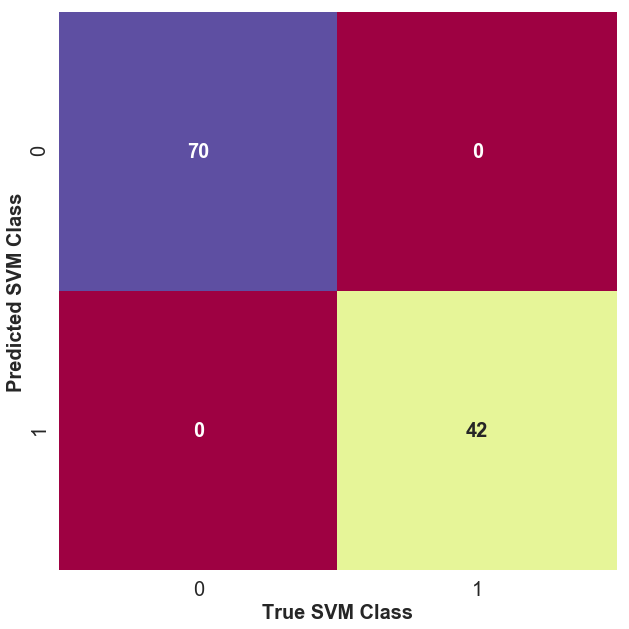

In [222]:
import matplotlib.pyplot as plt

sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, cmap="Spectral",annot_kws={"size": 20, "weight": 'bold'},
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel('True SVM Class',fontsize=20,fontweight='bold')
plt.ylabel('Predicted SVM Class',fontsize=20,fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('ConfusionMatrix_SVMClass.png')

In [126]:
UHB_svm_yfull_problemLevel = UHB_svm_fullset_merged['Problem Level']
UHB_svm_ytrain_problemLevel = UHB_svm_yfull_problemLevel[UHB_svm_yfull_problemLevel.index<140]
UHB_svm_ytest_problemLevel = UHB_svm_yfull_problemLevel[UHB_svm_yfull_problemLevel.index>=140]

In [227]:
UHB_svm_problemLevel = SVC(kernel='rbf', C=1,gamma='auto')
UHB_svm_problemLevel.fit(UHB_svm_xtrain,UHB_svm_ytrain_problemLevel)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

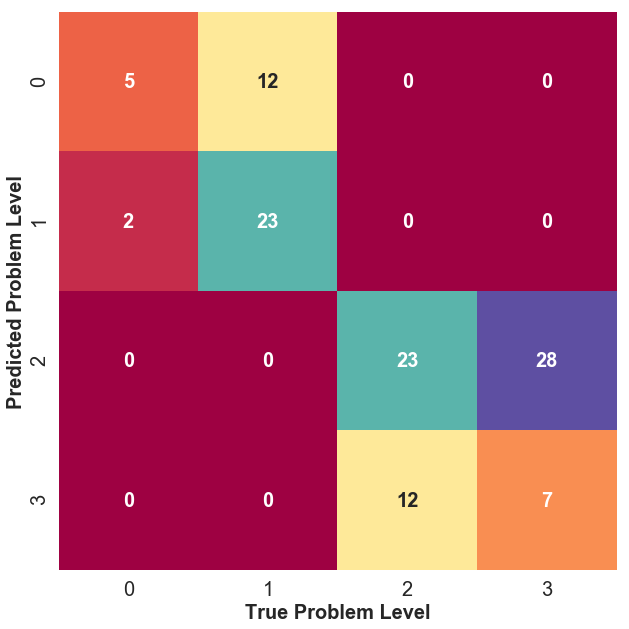

In [228]:
UHB_svm_ypredict_problemLevel = UHB_svm_problemLevel.predict(UHB_svm_xtest)
cm_problemLevel = confusion_matrix(UHB_svm_ytest_problemLevel,UHB_svm_ypredict_problemLevel)
sns.heatmap(cm_problemLevel.T, square=True, annot=True, fmt='d', cbar=False, cmap='Spectral',annot_kws={"size": 20, "weight": 'bold'},
            xticklabels=[0,1,2,3],
            yticklabels=[0,1,2,3])
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.xlabel('True Problem Level',fontsize=20,fontweight='bold')
plt.ylabel('Predicted Problem Level',fontsize=20,fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('ConfusionMatrix_ProblemLevel.png')

In [132]:
accuracy_score(UHB_svm_ytest_problemLevel,UHB_svm_ypredict_problemLevel)

0.5178571428571429

In [133]:
from sklearn.metrics import f1_score
f1_score(UHB_svm_ytest_problemLevel,UHB_svm_ypredict_problemLevel,average='weighted')

0.5137946813092162